# HFT PORJECT - 1

Names (NetID): <br />  
Liqin Guan (lg1656) <br />
Abhirit Kanti (ak7349) <br />
Supreeth Sundar (ss11346)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import datetime
import timeit
plt.style.use('ggplot')
from IPython.display import display, HTML

## Importing Tick Data

In [4]:
tick = pd.read_csv("./2.csv", encoding = "utf-16le", parse_dates = ["DateTime"]).set_index("DateTime")
tick.head()

,Bid,Ask
DateTime,,
2018-01-07 22:02:03.832,1.35560,1.35616
2018-01-07 22:02:03.845,1.35560,1.35617
2018-01-07 22:02:03.851,1.35554,1.35617
2018-01-07 22:02:03.859,1.35554,1.35618
2018-01-07 22:02:04.114,1.35554,1.35619


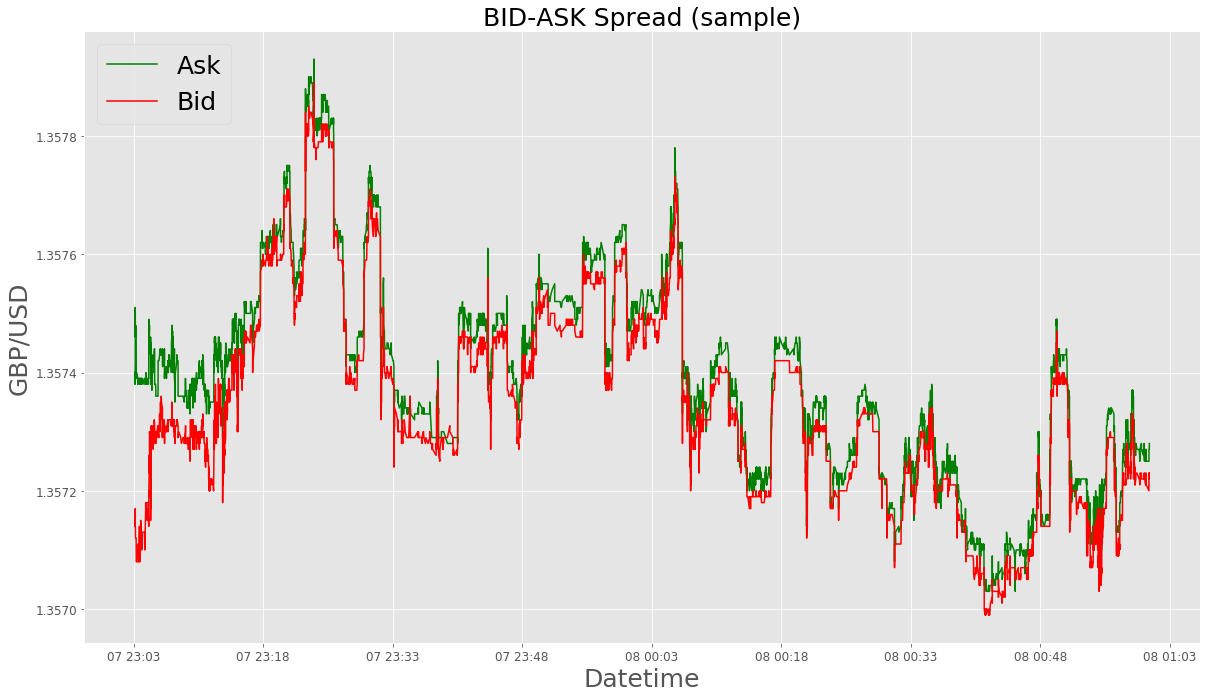

In [13]:
# modify date format, align plot
plt.figure(figsize= (20,11.25))
sample = tick.iloc[1000:10000,:] # changed from 1000:20000
plt.title("BID-ASK Spread (sample)", fontsize = 25)
plt.plot(sample.index,sample.Ask,label = 'Ask',color = 'g')
plt.plot(sample.index,sample.Bid,label = 'Bid',color = 'r')
plt.legend(loc = 2, fontsize = 25)
plt.xlabel('Datetime', fontsize = 25)
plt.ylabel('GBP/USD', fontsize = 25)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.show()

In [17]:
pd.set_option('precision', 3)
order = pd.read_csv("./Assignment#3_Orders.csv", header=3, parse_dates= ["datetime"]).dropna()
order.datetime = order.datetime + datetime.timedelta(hours = 5) #convert order time (EST) to tick time (GMT)
order = order.set_index("datetime")
order.head()

,trade_id,buy/sell,notional,price,instrument,alpha
datetime,,,,,,
2018-01-08 00:07:49.749000,107414.0,1.0,"150,000",1.357,GBP/USD,SOM
2018-01-08 00:15:23.152300,107427.0,1.0,"310,000",1.357,GBP/USD,SOM
2018-01-08 12:38:48.384800,107638.0,-1.0,"310,000",1.355,GBP/USD,SOM
2018-01-08 13:10:55.105500,107649.0,-1.0,"310,000",1.354,GBP/USD,SOM
2018-01-08 13:19:10.191000,107654.0,-1.0,"320,000",1.354,GBP/USD,SOM


# Market Taking

In [19]:
pd.set_option('precision', 5)
MT = pd.concat([tick, order], axis = 1)
MT["Bid"] = MT["Bid"].fillna(method = "ffill")
MT["Ask"] = MT["Ask"].fillna(method = "ffill")
MT = MT.drop(["price", "instrument","notional"], axis = 1).dropna()
MT.head(5)

,Bid,Ask,trade_id,buy/sell,alpha
2018-01-08 00:07:49.749000,1.35727,1.35731,107414.0,1.0,SOM
2018-01-08 00:15:23.152300,1.35719,1.35722,107427.0,1.0,SOM
2018-01-08 12:38:48.384800,1.35462,1.35466,107638.0,-1.0,SOM
2018-01-08 13:10:55.105500,1.35375,1.35379,107649.0,-1.0,SOM
2018-01-08 13:19:10.191000,1.35399,1.35403,107654.0,-1.0,SOM


Text(0.5,0.98,'DIS')

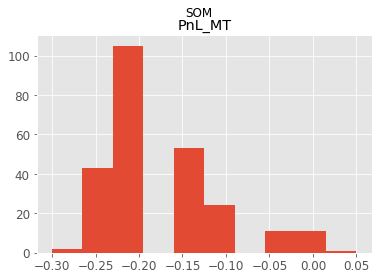

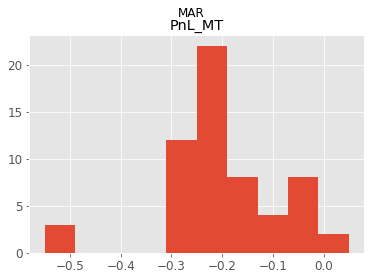

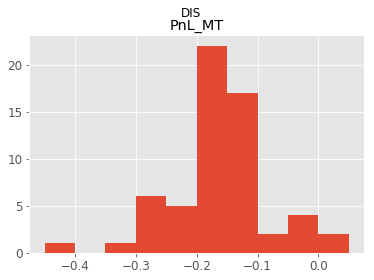

In [20]:
MT = MT.assign(spread = MT.Ask - MT.Bid)
MT = MT.assign(PnL_MT = -MT.spread/2*10000) #pips
MT = MT.assign(Mid = (MT.Ask + MT.Bid)/2)
som = MT.loc[(MT['alpha']=='SOM'),['PnL_MT','alpha']]
mar = MT.loc[(MT['alpha']=='MAR'),['PnL_MT','alpha']]
dis = MT.loc[(MT['alpha']=='DIS'),['PnL_MT','alpha']]
axes = som.hist()
pl.suptitle('SOM')
axes = mar.hist()
pl.suptitle('MAR')
axes = dis.hist()
pl.suptitle('DIS')
#MT

In [21]:
pd.set_option('precision', 3)
mean = MT.loc[:,["PnL_MT"]].mean()
std = MT.loc[:,["PnL_MT"]].std()
median = MT.loc[:,["PnL_MT"]].median()
information_ratio = mean / std;
mean_tte = 0;
median_tte = 0;
sl_trigger_count = 0;
timelimit_count = 0;
Analysis = pd.concat([mean,std,median,information_ratio],axis = 1)
Analysis.columns = ["Mean","Std_Dev","Median","Information Ratio"]
Analysis.transpose()

,PnL_MT
Mean,-0.177
Std_Dev,0.077
Median,-0.200
Information Ratio,-2.291


In [22]:
# Alpha-Wise Statistics
pd.set_option('precision', 3)
mean = MT.loc[:,["alpha", "PnL_MT"]].groupby('alpha').mean()
std = MT.loc[:,["alpha", "PnL_MT"]].groupby('alpha').std()
median = MT.loc[:,["alpha", "PnL_MT"]].groupby('alpha').median()
Analysis = pd.concat([mean,std,median],axis = 1)
Analysis.columns = ["Mean","Std_Dev","Median"]
Analysis.transpose()

alpha,DIS,MAR,SOM
Mean,-0.173,-0.197,-0.173
Std_Dev,0.078,0.113,0.065
Median,-0.200,-0.200,-0.200


## Time to Execution and Stop Loss Analysis

Since this is Market Taking, therefore there is no Stop Loss, and it is triggered 0 times. The orders are executed instantly by aggressing the offered market, and therefore average and median TTE is 0 seconds. The orders are always executed within the Time Limit.

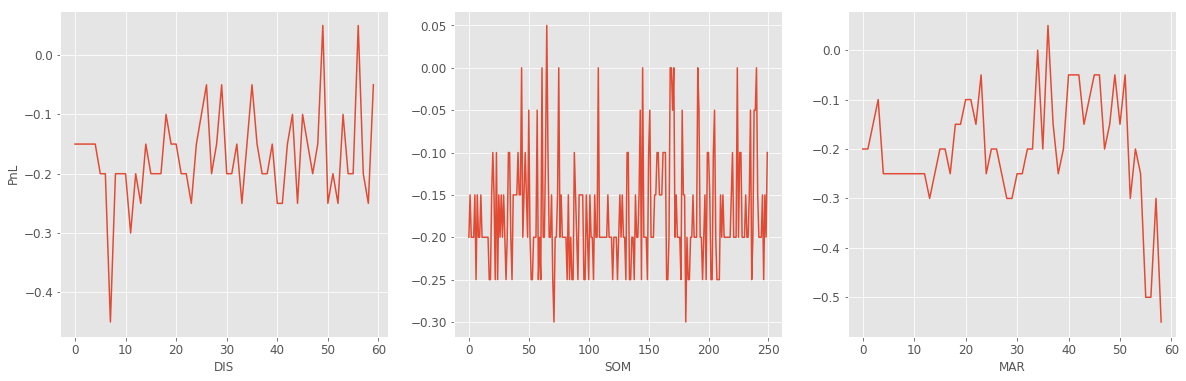

In [28]:
fig = plt.figure()
fig.set_size_inches(20,6)
ax = fig.add_subplot(1,3,1)
_ = ax.plot(np.arange(len(MT.loc[MT["alpha"] == "DIS"])),MT.loc[MT["alpha"] == "DIS"].loc[:, "PnL_MT"])
_ = ax.set_xlabel("DIS")
_ = ax.set_ylabel("PnL")

ax = fig.add_subplot(1,3,2)
_ = ax.plot(np.arange(len(MT.loc[MT["alpha"] == "SOM"])),MT.loc[MT["alpha"] == "SOM"].loc[:, "PnL_MT"])
_ = ax.set_xlabel("SOM")

ax = fig.add_subplot(1,3,3)
_ = ax.plot(np.arange(len(MT.loc[MT["alpha"] == "MAR"])),MT.loc[MT["alpha"] == "MAR"].loc[:, "PnL_MT"])
_ = ax.set_xlabel("MAR")

#plt.plot(np.arange(len(MT.loc[MT["alpha"] == "DIS"].PnL)), MT.loc[MT["alpha"] == "DIS"].PnL)
#plt.plot(np.arange(len(MT.loc[MT["alpha"] == "SOM"].PnL)), MT.loc[MT["alpha"] == "SOM"].PnL)

# OMMSide

In [33]:
pd.set_option('precision', 6)
OMMSide = MT.assign(SideLimit = MT.Bid) #for buy order
OMMSide = OMMSide.drop('PnL_MT', axis = 1)
OMMSide.loc[(OMMSide['buy/sell'] == -1), 'SideLimit'] = OMMSide.Ask
OMMSide['spread'] = OMMSide['spread'] * 10000 # pips
OMMSide.loc[OMMSide['alpha'] == 'MAR'].head()

,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit
2018-01-08 20:41:56.415600,1.35638,1.35642,107784.0,1.0,MAR,0.4,1.356400,1.35638
2018-01-08 20:41:57.415700,1.35638,1.35642,107785.0,1.0,MAR,0.4,1.356400,1.35638
2018-01-10 00:04:04.440000,1.35323,1.35326,108240.0,1.0,MAR,0.3,1.353245,1.35323
2018-01-10 09:08:43.843000,1.35128,1.35130,108503.0,-1.0,MAR,0.2,1.351290,1.35130
2018-01-10 10:38:25.382500,1.35113,1.35118,108559.0,1.0,MAR,0.5,1.351155,1.35113


In [34]:
OMMSideBuy = OMMSide.loc[OMMSide["buy/sell"] == 1]
OMMSideSell = OMMSide.loc[OMMSide["buy/sell"] == -1]
display(OMMSideBuy.head(),OMMSideSell.head())

,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit
2018-01-08 00:07:49.749000,1.35727,1.35731,107414.0,1.0,SOM,0.4,1.357290,1.35727
2018-01-08 00:15:23.152300,1.35719,1.35722,107427.0,1.0,SOM,0.3,1.357205,1.35719
2018-01-08 16:25:13.251300,1.35712,1.35715,107726.0,1.0,SOM,0.3,1.357135,1.35712
2018-01-08 16:42:08.428000,1.35690,1.35694,107733.0,1.0,SOM,0.4,1.356920,1.35690
2018-01-08 17:15:34.153400,1.35670,1.35674,107737.0,1.0,SOM,0.4,1.356720,1.35670


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit
2018-01-08 12:38:48.384800,1.35462,1.35466,107638.0,-1.0,SOM,0.4,1.354640,1.35466
2018-01-08 13:10:55.105500,1.35375,1.35379,107649.0,-1.0,SOM,0.4,1.353770,1.35379
2018-01-08 13:19:10.191000,1.35399,1.35403,107654.0,-1.0,SOM,0.4,1.354010,1.35403
2018-01-08 13:23:16.231600,1.35406,1.35409,107664.0,-1.0,SOM,0.3,1.354075,1.35409
2018-01-08 13:34:40.344000,1.35462,1.35467,107670.0,-1.0,SOM,0.5,1.354645,1.35467


## Helper Functions

In [36]:
def searchInsert(nums, target):
    '''
    This is simply binary search.
    The return would be the index of timestamp.
    '''
    start = 0
    end = len(nums) - 1
    while start <= end:
        mid = (start + end) // 2
        if nums[mid] == target:
            return mid
        elif nums[mid] < target:
            start = mid + 1
        else:
            end = mid - 1
    return end

#A showcase, delete it before submitting
time = order.index[11]
lst = tick.index
t = searchInsert(lst, time)
print(time, t)
tick.head()


2018-01-08 17:20:20.202000 190946


,Bid,Ask
DateTime,,
2018-01-07 22:02:03.832,1.35560,1.35616
2018-01-07 22:02:03.845,1.35560,1.35617
2018-01-07 22:02:03.851,1.35554,1.35617
2018-01-07 22:02:03.859,1.35554,1.35618
2018-01-07 22:02:04.114,1.35554,1.35619


In [37]:
def searchOMMSide(SL, TTE, t, tick, Order, target):
    '''
    input:
    SL -- Max Stop Loss
    TTE -- Max Time to execution
    t -- index of tick time that is right before order time 
    tick -- tick dataframe
    Order -- order dataframe
    target -- order time
    return:
    [0]: index of execution time
    [1]: if max SL is triggered
    [2]: if max TTE is triggered
    '''
    SL_flag = False
    TTE_flag = False
    for i in range (t+1, len(tick.index)):
        if (tick.index[i] == Order.index[target]+TTE):
            idx_OMM = i
            TTE_flag = True
            break
        if ((Order.index[target]+TTE > tick.index[i-1]) and (Order.index[target]+TTE < tick.index[i])):
            idx_OMM = i-1
            TTE_flag = True
            break
        if Order.iloc[target,:]["buy/sell"] == 1:
            if (tick.Ask[i] - Order.Ask[target] >= SL):
                idx_OMM = i
                SL_flag = True
                break
            elif (tick.Ask[i] <= Order.SideLimit[target]):
                idx_OMM = i
                break
        else:
            if (Order.Bid[target] - tick.Bid[i] >= SL):
                idx_OMM = i
                SL_flag = True
                break
            elif (tick.Bid[i] >= Order.SideLimit[target]):
                idx_OMM = i
                break
    return idx_OMM, SL_flag, TTE_flag

def Side(window, maxTTE, tick, Order):
    '''
    input: 
    tick -- tick data
    Order -- order data
    window -- rolling window
    maxTTE -- maximum time to execution
    
    return:
    dataframe.iloc[:, -4]: PnL_Side
    dataframe.iloc[:, -3]: TTE
    dataframe.iloc[:, -2]: if SL is triggered
    dataframe.iloc[:, -1]: if maxTTE is triggered
    
    When calculating PnL, I make it pips
    '''
    PnL = []
    TTElst = []
    SL_Triggered = []
    TTE_Triggered = []
    tick = tick.assign(rollingstdAsk = tick.Ask.rolling(window).std(),rollingstdBid = tick.Bid.rolling(window).std())
    for i in range(len(Order.index)):
        t = searchInsert(tick.index, Order.index[i])
        if Order.iloc[i,:]["buy/sell"] == 1:
            SL = (tick.rollingstdAsk[t])*Order.Ask[i]
        else:
            SL = (tick.rollingstdBid[t])*Order.Bid[i]
        execute = searchOMMSide(SL, maxTTE, t, tick, Order, i) #execute[0]:index of execution time; execute[1]/[2]: if SL/TTE is triggered
        
        if Order.iloc[i,:]["buy/sell"] == 1:
            PnL.append((Order.Mid[i]-tick.iloc[execute[0], :].Ask)*10000)
        else:
            PnL.append((tick.iloc[execute[0], :].Bid - Order.Mid[i])*10000)
        TTE = (tick.index[execute[0]]-Order.index[i]).total_seconds() 
        if execute[2] == False:
            TTElst.append(TTE)
        else:
            TTElst.append(maxTTE.total_seconds()) #if max TTE is triggered, equivalent to execute at max TTE
        SL_Triggered.append(execute[1])
        TTE_Triggered.append(execute[2])
    Order = Order.assign(PnL_Side = PnL, TTE = TTElst, SL_Triggered = SL_Triggered,SL_value = SL,TTE_Triggered = TTE_Triggered)
    return Order


## Analysis

In [42]:
# Function to print Statistics
def book_stats_side(df):
    PnL_Side_mean = df.PnL_Side.mean()
    PnL_Side_median = df.PnL_Side.median()
    PnL_Side_meanTTE = df.TTE.mean()
    PnL_Side_medianTTE = df.TTE.median()
    PnL_Side_SL_count = df.SL_Triggered.sum()
    PnL_Side_TTE_count = df.TTE_Triggered.count() - df.TTE_Triggered.sum()
    return [PnL_Side_mean, PnL_Side_median, PnL_Side_meanTTE, PnL_Side_medianTTE, PnL_Side_SL_count, PnL_Side_TTE_count]

In [43]:
pd.set_option('precision', 3)
window = 30
maxTTEarray = [1,3,5,10,15,20,25,30]
maxTTE1 = datetime.timedelta(seconds = 1)
book1_side = Side(window, maxTTE1, tick, OMMSide)

maxTTE2 = datetime.timedelta(seconds = 3)
book2_side = Side(window, maxTTE2, tick, OMMSide)

maxTTE3 = datetime.timedelta(seconds = 5)
book3_side = Side(window, maxTTE3, tick, OMMSide)

maxTTE4 = datetime.timedelta(seconds = 10)
book4_side = Side(window, maxTTE4, tick, OMMSide)

maxTTE5 = datetime.timedelta(seconds = 15)
book5_side = Side(window, maxTTE5, tick, OMMSide)

maxTTE6 = datetime.timedelta(seconds = 20)
book6_side = Side(window, maxTTE6, tick, OMMSide)

maxTTE7 = datetime.timedelta(seconds = 25)
book7_side = Side(window, maxTTE7, tick, OMMSide)

maxTTE8 = datetime.timedelta(seconds = 30)
book8_side = Side(window, maxTTE8, tick, OMMSide)

In [46]:
df_side = pd.DataFrame()
df_side.fillna(0)
df_side
books = [book1_side, book2_side, book3_side, book4_side, book5_side, book6_side, book7_side, book8_side]
for i in range(0,8):
    d = {'Mean PnL \$': book_stats_side(books[i])[0], 'Median PnL \$': book_stats_side(books[i])[1], 'Mean TTE (s)' : book_stats_side(books[i])[2],
         'Median TTE (s)': book_stats_side(books[i])[3], 'Stop Loss Trigger Count': book_stats_side(books[i])[4], 'Time Limit Execution Count' : book_stats_side(books[i])[5]}
    df_side=df_side.append(pd.DataFrame(data = d, index = ["TTE"+str(maxTTEarray[i])]))
df_side

,Mean PnL \$,Median PnL \$,Mean TTE (s),Median TTE (s),Stop Loss Trigger Count,Time Limit Execution Count
TTE1,-0.176,-0.20,0.849,1.000,56,104
TTE3,-0.159,-0.15,2.035,3.000,92,183
TTE5,-0.154,-0.20,2.898,3.017,114,226
TTE10,-0.149,-0.20,4.400,3.017,138,282
TTE15,-0.140,-0.15,5.355,3.017,151,309
TTE20,-0.139,-0.15,6.024,3.017,159,328
TTE25,-0.143,-0.20,6.520,3.017,165,336
TTE30,-0.150,-0.20,6.927,3.017,170,341


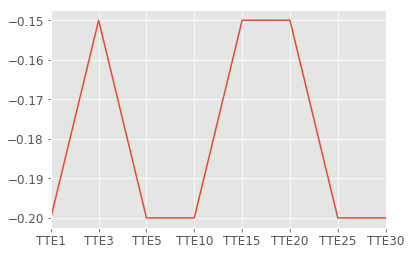

In [47]:
# Plot Max TTE vs Median PnL
df_side.iloc[:,1].plot()

In [48]:
# Calculating Pnl for different TTE
def analysis(OMM,strat,alpha):
    '''
    Input:
    OMM : Opportunity Market Making {OMMSide or OMMMid]
    strat: Strategy Mid or Side
    alpha : MAR or DIS or SOM
    
    Output:
    
    mean:   Average return of each strategy
    median: Median return of each strategy
    std_dev: Standard deviation of each strategy
    '''
    TTE_ls = [1,3,5,10,20,25,30]
    windows = [10,30,50,100]
    mean = pd.DataFrame()
    Std_dev = pd.DataFrame()
    median = pd.DataFrame()
    for tte in TTE_ls:
        maxTTE = datetime.timedelta(seconds = tte) #Passing different time to execution
        for window in windows:
            temp = strat(window, maxTTE, tick, OMM.loc[OMM['alpha'] == alpha])
            mean.loc[tte,str(window)] = temp.iloc[:,-4].mean()
            Std_dev.loc[tte,str(window)] = temp.iloc[:,-4].std()
            median.loc[tte,str(window)] = temp.iloc[:,-4].median()
    return mean,Std_dev,median

## By different alpha generators

In [49]:
def alpha_side(window, maxTTE8, tick, OMMSide):
    df = Side(window, maxTTE8, tick, OMMSide)
    result = pd.concat([df.loc[:,["alpha", "PnL_Side"]].groupby("alpha").mean().rename(columns = {"PnL_Side":"mean_PnL"}).round(4), 
               df.loc[:,["alpha", "PnL_Side"]].groupby("alpha").median().rename(columns = {"PnL_Side":"median_PnL"}).round(4),
               df.loc[:,["alpha", "TTE"]].groupby("alpha").median().rename(columns = {"TTE":"median_TTE"}).round(2),
               df.loc[:,["alpha", "TTE"]].groupby("alpha").mean().rename(columns = {"TTE":"mean_TTE"}).round(2),
               df.loc[:,["alpha", "SL_Triggered"]].loc[df["SL_Triggered"] == True].groupby("alpha").count(),
               df.loc[:,["alpha", "TTE_Triggered"]].loc[df["TTE_Triggered"] == True].groupby("alpha").count()],
              axis = 1)
    return result

### maxTTE = 1 sec

In [59]:
window = 30
maxTTE = datetime.timedelta(seconds = 1)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.203,-0.2,1.0,0.89,8,46
MAR,-0.174,-0.2,1.0,0.78,11,38
SOM,-0.171,-0.2,1.0,0.86,37,181


### maxTTE = 3 secs

In [60]:
maxTTE = datetime.timedelta(seconds = 3)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.186,-0.175,2.86,2.11,17,29
MAR,-0.164,-0.150,2.20,1.83,16,26
SOM,-0.152,-0.150,3.00,2.06,59,131


### maxTTE = 5 secs

In [61]:
maxTTE = datetime.timedelta(seconds = 5)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.194,-0.20,2.86,2.97,21,21
MAR,-0.174,-0.20,2.20,2.58,19,20
SOM,-0.140,-0.15,3.13,2.95,74,102


### maxTTE = 10 secs

In [62]:
maxTTE = datetime.timedelta(seconds = 10)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.171,-0.20,2.86,4.49,22,15
MAR,-0.186,-0.25,2.20,3.86,25,11
SOM,-0.136,-0.15,3.13,4.50,91,61


### maxTTE = 15 secs

In [63]:
maxTTE = datetime.timedelta(seconds = 15)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.126,-0.00,2.86,5.30,24,7
MAR,-0.175,-0.20,2.20,4.71,25,10
SOM,-0.134,-0.15,3.13,5.52,102,43


### maxTTE = 20 secs

In [64]:
maxTTE = datetime.timedelta(seconds = 20)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.134,-0.0,2.86,5.84,24,6
MAR,-0.169,-0.2,2.20,5.53,25,9
SOM,-0.133,-0.1,3.13,6.18,110,26


### maxTTE = 25 secs

In [65]:
maxTTE = datetime.timedelta(seconds = 25)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.133,-0.0,2.86,6.34,24,6
MAR,-0.160,-0.2,2.20,6.26,26,8
SOM,-0.142,-0.2,3.13,6.62,115,19


### maxTTE = 30 secs

In [66]:
maxTTE = datetime.timedelta(seconds = 30)
alpha_side(window, maxTTE, tick, OMMSide)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.128,-0.00,2.86,6.84,24,6
MAR,-0.192,-0.25,2.20,6.90,28,6
SOM,-0.145,-0.20,3.13,6.95,118,16


# OMMMid

In [67]:
OMMMid = MT.assign(MidLimit = MT.Mid)
OMMMid.head()

,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354


## Helper Functions

In [69]:
def searchOMMMid(SL, TTE, t, tick, Order, target):
    '''
    input:
    SL -- Max Stop Loss
    TTE -- Max Time to execution
    t -- index of tick time that is right before order time 
    tick -- tick dataframe
    Order -- order dataframe
    target -- order time
    
    return:
    [0]: index of execution time
    [1]: if max SL is triggered
    [2]: if max TTE is triggered
    '''
    SL_flag = False
    TTE_flag = False
    for i in range (t+1, len(tick.index)):
        if (tick.index[i] == Order.index[target]+TTE):
            idx_OMM = i
            TTE_flag = True
            break
        if ((Order.index[target]+TTE > tick.index[i-1]) and (Order.index[target]+TTE < tick.index[i])):
            idx_OMM = i-1
            TTE_flag = True
            break
        if Order.iloc[target,:]["buy/sell"] == 1:
            if (tick.Ask[i] - Order.Ask[target] >= SL):
                idx_OMM = i
                SL_flag = True
                break
            elif (tick.Ask[i] <= Order.MidLimit[target]):
                idx_OMM = i
                break
        else:
            if (Order.Bid[target] - tick.Bid[i] >= SL):
                idx_OMM = i
                SL_flag = True
                break
            elif (tick.Bid[i] >= Order.MidLimit[target]):
                idx_OMM = i
                break
    return idx_OMM, SL_flag, TTE_flag

def Mid(window, maxTTE, tick, Order):
    '''
    input: 
    tick -- tick data
    Order -- order data
    window -- rolling window
    maxTTE -- maximum time to execution
    
    return:
    dataframe.iloc[:, -4]: PnL_Mid
    dataframe.iloc[:, -3]: TTE
    dataframe.iloc[:, -2]: if SL is triggered
    dataframe.iloc[:, -1]: if maxTTE is triggered
    
    When calculating PnL, I make it pips
    '''
    PnL = []
    TTElst = []
    SL_Triggered = []
    TTE_Triggered = []
    tick = tick.assign(rollingstdAsk = tick.Ask.rolling(window).std(),rollingstdBid = tick.Bid.rolling(window).std())
    for i in range(len(Order.index)):
        t = searchInsert(tick.index, Order.index[i])
        if Order.iloc[i,:]["buy/sell"] == 1:
            SL = tick.rollingstdAsk[t]*Order.Ask[i]
        else:
            SL = tick.rollingstdBid[t]*Order.Bid[i]
        execute = searchOMMMid(SL, maxTTE, t, tick, Order, i) #execute[0]:index of execution time; execute[1]/[2]: if SL/TTE is triggered
        
        if Order.iloc[i,:]["buy/sell"] == 1:
            PnL.append((Order.Mid[i]-tick.iloc[execute[0], :].Ask)*10000)
        else:
            PnL.append((tick.iloc[execute[0], :].Bid - Order.Mid[i])*10000)
        TTE = (tick.index[execute[0]]-Order.index[i]).total_seconds() 
        if execute[2] == False:
            TTElst.append(TTE)
        else:
            TTElst.append(maxTTE.total_seconds()) #if max TTE is triggered, equivalent to execute at max TTE
        SL_Triggered.append(execute[1])
        TTE_Triggered.append(execute[2])
    Order = Order.assign(PnL_Mid = PnL, TTE = TTElst, SL_Triggered = SL_Triggered, TTE_Triggered = TTE_Triggered)
    return Order


In [70]:
# Function to print Statistics
def book_stats_mid(df):
    PnL_Mid_mean = df.PnL_Mid.mean()
    PnL_Mid_median = df.PnL_Mid.median()
    PnL_Mid_meanTTE = df.TTE.mean()
    PnL_Mid_medianTTE = df.TTE.median()
    PnL_Mid_SL_count = df.SL_Triggered.sum()
    PnL_Mid_TTE_count = df.TTE_Triggered.count() - df.TTE_Triggered.sum()
    return [PnL_Mid_mean, PnL_Mid_median, PnL_Mid_meanTTE, PnL_Mid_medianTTE, PnL_Mid_SL_count, PnL_Mid_TTE_count]

In [74]:
window = 30
maxTTEarray = [1,3,5,10,15,20,25,30]
maxTTE1 = datetime.timedelta(seconds = 1)
book1_mid = Mid(window, maxTTE1, tick, OMMMid)

maxTTE2 = datetime.timedelta(seconds = 3)
book2_mid = Mid(window, maxTTE2, tick, OMMMid)

maxTTE3 = datetime.timedelta(seconds = 5)
book3_mid = Mid(window, maxTTE3, tick, OMMMid)

maxTTE4 = datetime.timedelta(seconds = 10)
book4_mid = Mid(window, maxTTE4, tick, OMMMid)

maxTTE5 = datetime.timedelta(seconds = 15)
book5_mid = Mid(window, maxTTE5, tick, OMMMid)

maxTTE6 = datetime.timedelta(seconds = 20)
book6_mid = Mid(window, maxTTE6, tick, OMMMid)

maxTTE7 = datetime.timedelta(seconds = 25)
book7_mid = Mid(window, maxTTE7, tick, OMMMid)

maxTTE8 = datetime.timedelta(seconds = 30)
book8_mid = Mid(window, maxTTE8, tick, OMMMid)

In [77]:
pd.set_option('precision', 3)
df_mid = pd.DataFrame()
df_mid.fillna(0)
df_mid
books = [book1_mid, book2_mid, book3_mid, book4_mid, book5_mid, book6_mid, book7_mid, book8_mid]
for i in range(0,8):
    d = {'Mean PnL': book_stats_mid(books[i])[0], 'Median PnL': book_stats_mid(books[i])[1], 'Mean TTE' : book_stats_mid(books[i])[2],
         'Median TTE': book_stats_mid(books[i])[3], 'Stop Loss Trigger Count': book_stats_mid(books[i])[4], 'Time Limit Execution Count' : book_stats_mid(books[i])[5]}
    df_mid=df_mid.append(pd.DataFrame(data = d, index = ["TTE"+str(maxTTEarray[i])]))
    
df_mid

,Mean PnL,Median PnL,Mean TTE,Median TTE,Stop Loss Trigger Count,Time Limit Execution Count
TTE1,-0.180,-0.20,0.792,1.00,54,132
TTE3,-0.173,-0.15,1.810,1.96,86,214
TTE5,-0.174,-0.15,2.499,1.96,106,258
TTE10,-0.175,-0.05,3.651,1.96,124,301
TTE15,-0.170,0.00,4.330,1.96,137,332
TTE20,-0.173,0.00,4.776,1.96,143,340
TTE25,-0.174,0.00,5.122,1.96,147,346
TTE30,-0.178,0.00,5.394,1.96,151,351


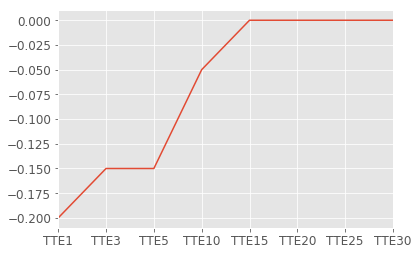

In [78]:
df_mid.iloc[:,1].plot()

## By different alpha generators

In [79]:
def alpha_mid(window, maxTTE, tick, OMMMid):
    df = Mid(window, maxTTE, tick, OMMMid)
    result = pd.concat([df.loc[:,["alpha", "PnL_Mid"]].groupby("alpha").mean().rename(columns = {"PnL_Mid":"mean_PnL"}).round(4), 
               df.loc[:,["alpha", "PnL_Mid"]].groupby("alpha").median().rename(columns = {"PnL_Mid":"median_PnL"}).round(4),
               df.loc[:,["alpha", "TTE"]].groupby("alpha").median().rename(columns = {"TTE":"median_TTE"}).round(2),
               df.loc[:,["alpha", "TTE"]].groupby("alpha").mean().rename(columns = {"TTE":"mean_TTE"}).round(2),
               df.loc[:,["alpha", "SL_Triggered"]].loc[df["SL_Triggered"] == True].groupby("alpha").count(),
               df.loc[:,["alpha", "TTE_Triggered"]].loc[df["TTE_Triggered"] == True].groupby("alpha").count()],
              axis = 1)
    return result

### maxTTE = 1 sec

In [80]:
window = 30
maxTTE = datetime.timedelta(seconds = 1)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.189,-0.2,1.0,0.81,8,38
MAR,-0.187,-0.2,1.0,0.70,11,32
SOM,-0.176,-0.2,1.0,0.81,35,167


### maxTTE = 3 secs

In [81]:
maxTTE = datetime.timedelta(seconds = 3)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.188,-0.15,1.88,1.82,16,23
MAR,-0.186,-0.15,1.42,1.56,15,21
SOM,-0.167,-0.15,2.10,1.87,55,111


### maxTTE = 5 secs

In [82]:
maxTTE = datetime.timedelta(seconds = 5)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.204,-0.15,1.88,2.48,20,16
MAR,-0.198,-0.20,1.42,2.12,17,16
SOM,-0.161,-0.15,2.10,2.59,69,79


### maxTTE = 10 secs

In [83]:
maxTTE = datetime.timedelta(seconds = 10)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.199,-0.075,1.88,3.62,21,10
MAR,-0.192,0.000,1.42,2.92,20,7
SOM,-0.166,-0.075,2.10,3.83,83,51


### maxTTE = 15 secs

In [84]:
maxTTE = datetime.timedelta(seconds = 15)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.191,0.0,1.88,4.16,23,5
MAR,-0.186,0.0,1.42,3.50,20,6
SOM,-0.162,0.0,2.10,4.57,94,26


### maxTTE = 20 secs

In [85]:
maxTTE = datetime.timedelta(seconds = 20)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.201,0.0,1.88,4.58,23,5
MAR,-0.175,0.0,1.42,4.01,20,6
SOM,-0.165,0.0,2.10,5.01,100,18


### maxTTE = 25 secs

In [86]:
maxTTE = datetime.timedelta(seconds = 25)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.199,0.0,1.88,4.99,23,5
MAR,-0.175,0.0,1.42,4.48,21,5
SOM,-0.168,0.0,2.10,5.30,103,13


### maxTTE = 30 secs

In [87]:
maxTTE = datetime.timedelta(seconds = 30)
alpha_mid(window, maxTTE, tick, OMMMid)

,mean_PnL,median_PnL,median_TTE,mean_TTE,SL_Triggered,TTE_Triggered
alpha,,,,,,
DIS,-0.196,0.0,1.88,5.41,23,5
MAR,-0.201,0.0,1.42,4.87,23,3
SOM,-0.168,0.0,2.10,5.51,105,10


# Annex

## Market Taking

In [88]:
MT

,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357


## OMM Side

In [89]:
display(book1_side)
display(book2_side)
display(book3_side)
display(book4_side)
display(book5_side)
display(book6_side)
display(book7_side)
display(book8_side)

,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.15,1.000,False,6.169e-05,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.20,1.000,False,6.169e-05,True
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,-0.20,1.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-0.15,1.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.25,1.000,False,6.169e-05,True
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.20,1.000,False,6.169e-05,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-4.000e-01,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-1.500e-01,3.000,False,6.169e-05,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-4.000e-01,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,2.220e-12,3.000,False,6.169e-05,True
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,-2.000e-01,3.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-1.500e-01,3.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,2.500e-01,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-3.500e-01,3.000,False,6.169e-05,True
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,2.000e-01,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-2.000e-01,3.000,False,6.169e-05,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.15,5.000,False,6.169e-05,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.20,5.000,False,6.169e-05,True
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,-0.20,5.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-0.15,5.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.20,5.000,False,6.169e-05,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.35,5.427,True,6.169e-05,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.50,7.003,True,6.169e-05,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,-0.20,10.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-0.15,10.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.30,10.000,False,6.169e-05,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.35,5.427,True,6.169e-05,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.50,7.003,True,6.169e-05,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,-0.20,15.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-0.15,15.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.40,11.326,True,6.169e-05,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.35,5.427,True,6.169e-05,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.50,7.003,True,6.169e-05,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,0.10,20.000,False,6.169e-05,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,-0.05,20.000,False,6.169e-05,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.40,11.326,True,6.169e-05,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.35,5.427,True,6.169e-05,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.50,7.003,True,6.169e-05,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,0.20,20.167,False,6.169e-05,False
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,0.25,23.021,False,6.169e-05,False
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.40,11.326,True,6.169e-05,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,Mid,SideLimit,PnL_Side,TTE,SL_Triggered,SL_value,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,0.4,1.357,1.357,-0.40,0.492,True,6.169e-05,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,0.3,1.357,1.357,-0.35,5.427,True,6.169e-05,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,0.4,1.355,1.355,-0.40,0.596,True,6.169e-05,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,0.4,1.354,1.354,-0.50,7.003,True,6.169e-05,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,0.4,1.354,1.354,0.20,20.167,False,6.169e-05,False
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,0.3,1.354,1.354,0.25,23.021,False,6.169e-05,False
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,0.5,1.355,1.355,0.25,0.846,False,6.169e-05,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,0.3,1.357,1.357,-0.45,3.941,True,6.169e-05,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,0.4,1.357,1.357,0.20,0.567,False,6.169e-05,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,0.4,1.357,1.357,-0.40,11.326,True,6.169e-05,False


## OMM Mid

In [90]:
display(book1_mid)
display(book2_mid)
display(book3_mid)
display(book4_mid)
display(book5_mid)
display(book6_mid)
display(book7_mid)
display(book8_mid)

,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-0.40,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-0.15,1.000,False,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-0.40,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-0.20,1.000,False,True
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-0.20,1.000,False,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-0.15,1.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,0.05,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-0.25,1.000,False,True
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,0.10,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-0.20,1.000,False,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-1.500e-01,3.000,False,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-2.000e-01,3.000,False,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-1.500e-01,3.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,3.000,False,True
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-2.000e-01,3.000,False,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-1.500e-01,5.000,False,True
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-2.000e-01,5.000,False,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-1.500e-01,5.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-2.000e-01,5.000,False,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,5.427,True,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-2.000e-01,10.000,False,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-1.500e-01,10.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-3.000e-01,10.000,False,True


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,5.427,True,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,-2.000e-01,15.000,False,True
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-1.500e-01,15.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,11.326,True,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,5.427,True,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,1.000e-01,16.878,False,False
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,-5.000e-02,20.000,False,True
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,11.326,True,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,5.427,True,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,1.000e-01,16.878,False,False
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,5.000e-02,23.016,False,False
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,11.326,True,False


,Bid,Ask,trade_id,buy/sell,alpha,spread,PnL_MT,Mid,MidLimit,PnL_Mid,TTE,SL_Triggered,TTE_Triggered
2018-01-08 00:07:49.749000,1.357,1.357,107414.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,0.492,True,False
2018-01-08 00:15:23.152300,1.357,1.357,107427.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-3.500e-01,5.427,True,False
2018-01-08 12:38:48.384800,1.355,1.355,107638.0,-1.0,SOM,4.000e-05,-0.20,1.355,1.355,-4.000e-01,0.596,True,False
2018-01-08 13:10:55.105500,1.354,1.354,107649.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,2.220e-12,1.867,False,False
2018-01-08 13:19:10.191000,1.354,1.354,107654.0,-1.0,SOM,4.000e-05,-0.20,1.354,1.354,1.000e-01,16.878,False,False
2018-01-08 13:23:16.231600,1.354,1.354,107664.0,-1.0,SOM,3.000e-05,-0.15,1.354,1.354,5.000e-02,23.016,False,False
2018-01-08 13:34:40.344000,1.355,1.355,107670.0,-1.0,SOM,5.000e-05,-0.25,1.355,1.355,5.000e-02,0.830,False,False
2018-01-08 16:25:13.251300,1.357,1.357,107726.0,1.0,SOM,3.000e-05,-0.15,1.357,1.357,-4.500e-01,3.941,True,False
2018-01-08 16:42:08.428000,1.357,1.357,107733.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,1.000e-01,0.560,False,False
2018-01-08 17:15:34.153400,1.357,1.357,107737.0,1.0,SOM,4.000e-05,-0.20,1.357,1.357,-4.000e-01,11.326,True,False


In [91]:
#test for running time
import timeit

start = timeit.default_timer()

for i in [1,3,5,10,15,20,25,30]:
    for j in [10,30,50,100]:
        window = j
        maxTTE = datetime.timedelta(seconds = i)
        Side(window, maxTTE, tick, OMMSide)

stop = timeit.default_timer()

print('Time: {r:2.4f} seconds'.format(r= stop - start))  


Time: 71.8654 seconds
